In [131]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris 
from tqdm import tqdm
from scipy.sparse import csr_matrix
from lib.gradient_tools import BasicGradientUpdater
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics.pairwise import linear_kernel
from lib.sparse_tools import sparse_clip, sparse_pos_clip, dense_pos_clip, sparse_sparse_dot, dense_sparse_add, \
                             dense_sparse_mul, sparse_sub_with_clip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
with open("bernstein_km.dump", "rb") as fin:
    km = pickle.load(fin)

n = km.shape[0]

In [9]:
iris_data = load_iris()

In [10]:
km = csr_matrix(linear_kernel(iris_data["data"]))
n = km.shape[0]
y = iris_data["target"]
y[y > 0] = 1

In [298]:
%%time
y = [0] * 50 + [1]*100
clf = SVC(kernel="precomputed", probability=True)
clf.fit(km.toarray(), y)
print(classification_report(y, clf.predict(km.toarray())))
print(roc_auc_score(y, clf.predict_proba(km.toarray())[:, 1]))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00       100

avg / total       1.00      1.00      1.00       150

1.0
CPU times: user 5.05 ms, sys: 2.97 ms, total: 8.02 ms
Wall time: 7.1 ms


In [299]:
clf.support_

array([23, 41, 98], dtype=int32)

In [300]:
# Input:
# km: csr_matrix
# y: np.array

C = 1.0
γ = 1000. # O(n)
L1 = 2*γ
ε = 1e-3
n_iter = 1000
inv2nC = 1. / (2 * n * C)
invL1 = 1. / L1
fracCL1 = C / L1

y = np.array([+1.] * 50 + [-1.] * 100)

γy = γ * y

In [301]:
dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν))).data

array([-0.55129684, -0.551243  , -0.55982112, -0.55235906, -0.55348932,
       -0.53308673, -0.55670857, -0.54802793, -0.55840072, -0.54942995,
       -0.54369681, -0.54695151, -0.55454736, -0.57491868, -0.55194515,
       -0.53996852, -0.54985936, -0.54955084, -0.52952351, -0.54726003,
       -0.53340815, -0.54487992, -0.57649542, -0.53221115, -0.53437204,
       -0.54129832, -0.54034279, -0.54554531, -0.54910436, -0.54724165,
       -0.54504917, -0.53830247, -0.551096  , -0.54950217, -0.54942995,
       -0.55933918, -0.54925653, -0.54942995, -0.563228  , -0.54646957,
       -0.55530237, -0.55548483, -0.56449623, -0.53748491, -0.5287414 ,
       -0.55105537, -0.54481287, -0.55718633, -0.54525518, -0.55158698,
        1.23954064,  1.22355012,  1.2487487 ,  1.19077406,  1.2318381 ,
        1.21168601,  1.23148994,  1.14619965,  1.22927036,  1.18111534,
        1.15868079,  1.20444703,  1.19396203,  1.22741768,  1.17175511,
        1.22292018,  1.2123514 ,  1.19186788,  1.22677453,  1.18

In [302]:
def grad_f(x):
    t = x.copy()
    t.data -= 1 / (2 * n * C)
    return (-csr_matrix([1] * n).T + km.multiply(y.reshape(1, -1) * y.reshape(-1, 1)).dot(x.T) + \
           γ*sparse_clip(-x.T, 0, None) + γ*sparse_clip(t.T, 0, None)).T

In [303]:
%%time

# Initialize gradient heap

ν = csr_matrix(([1., -1.], [0, 1], [0, 2]), shape=(1, n))

grad1 = dense_sparse_add(-y, 2 * (km[0] - km[1]))

yν_ = dense_sparse_mul(y, ν)
yν1 = sparse_pos_clip(-yν_)
yν2 = sparse_sub_with_clip(yν_, inv2nC)
grad2 = dense_sparse_mul(γy, yν1 + yν2)

grad = dense_sparse_add(grad1, grad2)
min_heap = BasicGradientUpdater(grad)
max_heap = BasicGradientUpdater(-grad)

# Iterate until stopping criteria is met

norms = []

for t in tqdm(range(n_iter)):
    if min_heap.get_norm() <= ε:
        break
    norms.append(min_heap.get_norm())
    ν_prev = ν.copy()
    min_ix = min_heap.get_coordinate()
    max_ix = max_heap.get_coordinate()
    min_val = min_heap.get_value()
    max_val = -max_heap.get_value()
    h_val = fracCL1 * (min_val - max_val)
    h_vec = csr_matrix(([+h_val, -h_val], [min_ix, max_ix], [0, 2]), shape=(1, n))
    h_vec.sort_indices()
    ν += invL1 * h_vec
    assert np.abs(ν.sum()) <= 1e-6
    assert (min_heap.get() == -max_heap.get()).all()

    # Gradient update
#     νinvL1h = ν_prev + invL1 * h_vec
#     δ1 = (2 * h_val / L1) * (km[min_ix] - km[max_ix])
#     δ21 =  sparse_pos_clip(dense_sparse_mul(-y, νinvL1h))
#     δ22 = -sparse_pos_clip(dense_sparse_mul(-y, ν_prev))
#     δ23 =  sparse_sub_with_clip(dense_sparse_mul(y, νinvL1h), inv2nC)
#     δ24 = -sparse_sub_with_clip(dense_sparse_mul(y, ν_prev), inv2nC)
#     δ2 = dense_sparse_mul(γy, δ21 + δ22 + δ23 + δ24)
#     δ = δ1 + δ2
    δ = np.asarray(dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν))) - min_heap.get())[0]
    min_heap.update(δ)
    max_heap.update(-δ)

λ = dense_sparse_mul(y, ν)

100%|██████████| 1000/1000 [00:02<00:00, 339.90it/s]

CPU times: user 2.86 s, sys: 70.1 ms, total: 2.93 s
Wall time: 2.95 s


In [304]:
%%time

# Initialize gradient heap

ν = csr_matrix(([0., 0.], [1, 2], [0, 2]), shape=(1, n))

grad1 = dense_sparse_add(-y, 2 * (km[0] - km[1]))

yν_ = dense_sparse_mul(y, ν)
yν1 = sparse_pos_clip(-yν_)
yν2 = sparse_sub_with_clip(yν_, inv2nC)
grad2 = dense_sparse_mul(γy, yν1 + yν2)

grad = dense_sparse_add(grad1, grad2)
min_heap = BasicGradientUpdater(grad)
max_heap = BasicGradientUpdater(-grad)

# Iterate until stopping criteria is met

norms = []
h_vals = []

for t in range(n_iter):
    if min_heap.get_norm() <= ε:
        break
    ν_prev = ν.copy()
    
    # math
    current_grad = dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν)))
    norms.append(sparse.linalg.norm(current_grad))
    
    # anikin
    min_ix = current_grad.argmin()#min_heap.get_coordinate()
    max_ix = current_grad.argmax()#max_heap.get_coordinate()
    min_val = current_grad.min()
    max_val = current_grad.max()
    h_val = fracCL1 * (max_val - min_val)
    h_vec = csr_matrix(([-h_val, +h_val], [min_ix, max_ix], [0, 2]), shape=(1, n))
    h_vec.sort_indices()
    h_vals.append(h_val)
    #print(t, h_val, min_ix, max_ix)
    
    # Yura
    ν +=  h_vec
    assert np.abs(ν.sum()) <= 1e-6
    assert (min_heap.get() == -max_heap.get()).all()

    # Gradient update
#     νinvL1h = ν_prev + invL1 * h_vec
#     δ1 = (2 * h_val / L1) * (km[min_ix] - km[max_ix])
#     δ21 =  sparse_pos_clip(dense_sparse_mul(-y, νinvL1h))
#     δ22 = -sparse_pos_clip(dense_sparse_mul(-y, ν_prev))
#     δ23 =  sparse_sub_with_clip(dense_sparse_mul(y, νinvL1h), inv2nC)
#     δ24 = -sparse_sub_with_clip(dense_sparse_mul(y, ν_prev), inv2nC)
#     δ2 = dense_sparse_mul(γy, δ21 + δ22 + δ23 + δ24)
#     δ = δ1 + δ2
    #δ = np.asarray(dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν))) - min_heap.get())[0]
    #min_heap.update(δ)
    #max_heap.update(-δ)

λ = dense_sparse_mul(y, ν)

CPU times: user 3.1 s, sys: 56.1 ms, total: 3.15 s
Wall time: 3.19 s


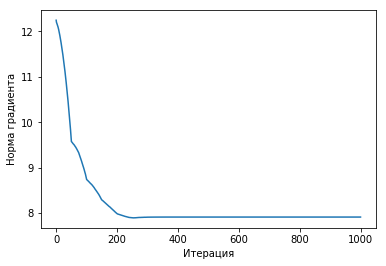

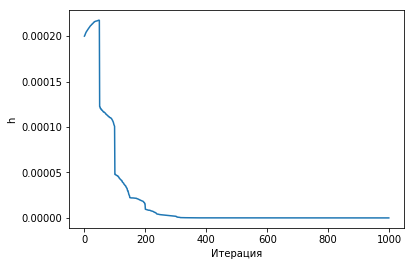

In [295]:
plt.xlabel("Итерация")
plt.ylabel("Норма градиента")
plt.plot(norms)
plt.show()
plt.xlabel("Итерация")
plt.ylabel("h")
plt.plot(h_vals)
plt.show()

In [248]:
λ.data.sum()

-0.029872775160929406

---